In [96]:
# %pip install umap
# %pip install umap-learn

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer

In [98]:
base_path = 'C:/Eugenio/Maestria/DMEyF/'

dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'

dataset_file = 'competencia_01.csv'

In [99]:
data = pd.read_csv(dataset_path + dataset_file)

Solo segmentaremos a los clientes de abril, dado que necesitaremos variables en algún momento agregar variables históricas para entender su comportamiento previo a la **baja**

In [100]:
df_train = data[data['foto_mes'] == 202104].copy()

A su vez, nos concentraremos en el fenómeno de la **baja**. No importa si es en un mes o si es en dos.

In [101]:
Xtrain = df_train
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
Xtrain = Xtrain.drop("clase_ternaria", axis=1)

del(df_train)

### Random forest distance

In [102]:
# tomamos todos los baja y voy a tomar 2000 continua (probe tambien tomar 10.000 continua pero no me sirvio mucho)

np.random.seed(109279)
continua_sample = ytrain[ytrain == 0].sample(2000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

Xtrain_rf = Xtrain.loc[rf_index]
ytrain_rf = ytrain.loc[rf_index]

In [103]:
Xtrain_rf.shape

(4171, 154)

In [104]:
# entrenamos el random forest (imputando missings con la mediana)

# imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
# Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf)

# model = RandomForestClassifier(n_estimators=100,
#                                max_features=20,
#                                min_samples_leaf=400,
#                                random_state=109279)

# model.fit(Xtrain_rf_imp, ytrain_rf)

RandomForestClassifier(max_features=20, min_samples_leaf=400, random_state=35)

In [34]:
# entrenamos el random forest (sin imputar missings)

# scikit-learn added missing values support for random forest in v.1.4
# https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_1_4_0.html
# "When training every individual tree, the splitter evaluates each potential threshold with the missing values going to the left and right nodes."

model = RandomForestClassifier(n_estimators=100,
                               max_features=20,
                               min_samples_leaf=400,
                               random_state=109279)

model.fit(Xtrain_rf, ytrain_rf)

RandomForestClassifier(max_features=20, min_samples_leaf=400,
                       random_state=401537)

In [105]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

md = distanceMatrix(model, Xtrain_rf)

c:\Users\eaneg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [58]:
md.shape

(4171, 4171)

In [59]:
md

array([[0.  , 0.82, 0.93, ..., 0.75, 0.93, 0.78],
       [0.82, 0.  , 0.58, ..., 0.99, 1.  , 1.  ],
       [0.93, 0.58, 0.  , ..., 0.99, 1.  , 0.99],
       ...,
       [0.75, 0.99, 0.99, ..., 0.  , 0.49, 0.5 ],
       [0.93, 1.  , 1.  , ..., 0.49, 0.  , 0.61],
       [0.78, 1.  , 0.99, ..., 0.5 , 0.61, 0.  ]])

### Embedding

Para poder visualizar la matriz, utilizaremos un embedding. Los *embeddings* son representaciones vectoriales de datos en un espacio de menor dimensión

Podría utilizar un **PCA** con ese fin, pero en los últimos años hay mejores algoritmos como **t-sne** o **umap**.

UMAP (Uniform Manifold Approximation and Projection) es una técnica avanzada para la reducción de dimensionalidad y visualización de datos en espacios de menor dimensión, que busca mantener al máximo la estructura de los datos en alta dimensión.

c:\Users\eaneg\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\eaneg\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


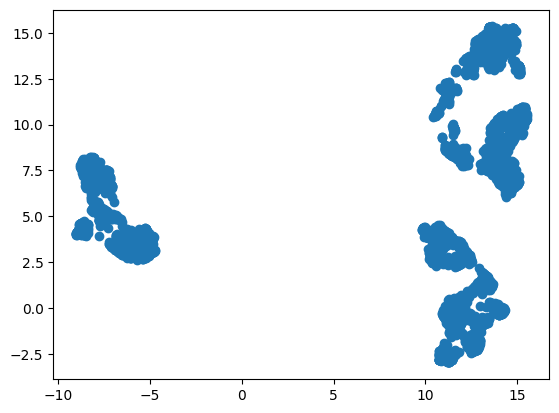

In [106]:
embedding_rf = UMAP(
  n_components=2,
  n_neighbors=50,
  metric="precomputed",
  random_state=109279,
).fit_transform(md)

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

c:\Users\eaneg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


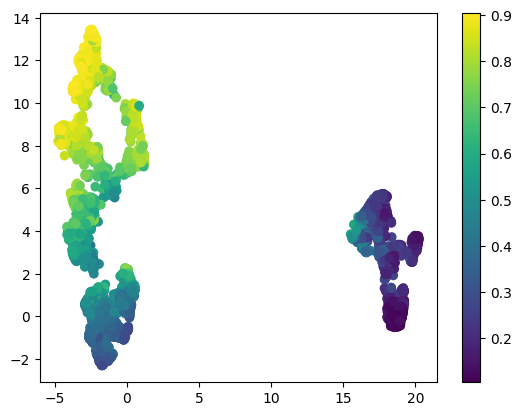

In [95]:
class_index = np.where(model.classes_ == 1)[0]
prob_baja = model.predict_proba(Xtrain_rf)[:,class_index]

plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja)
plt.colorbar()
plt.show()

In [20]:
embedding_rf.shape

(12171, 2)

### Segmentacion

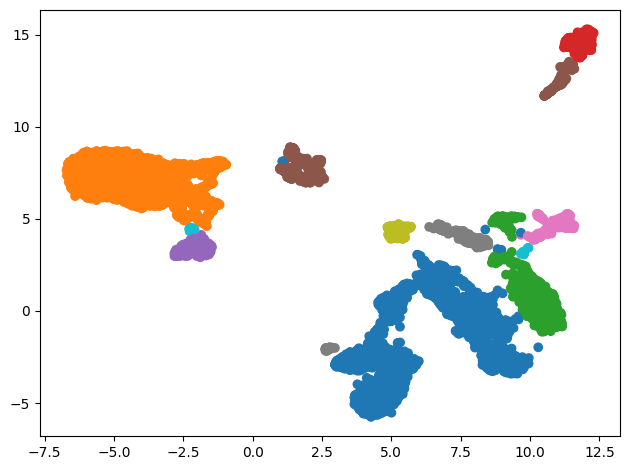

In [21]:
hdb = DBSCAN(eps=0.3)
y = hdb.fit(embedding_rf)

plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y.labels_, cmap='tab10')
plt.tight_layout()
plt.show()

In [22]:
pd.Series(y.labels_).value_counts() # los que tienen -1 son outliers que no fueron asignados a ningun cluster

 0     4329
 1     4238
 3     1060
 7      525
 5      404
 4      385
 8      374
 6      243
 2      194
 10     190
 11     158
 9       30
 12      23
-1       11
 13       7
Name: count, dtype: int64

### Variables de separacion

Usaremos random forests para ver que variables son las que distinguen a cada cluster respecto de los demas.

In [24]:
df_embedding = pd.DataFrame(embedding_rf, columns=['embedding_1', 'embedding_2'])
df_embedding['cluster'] = y.labels_

clusters = df_embedding['cluster'].unique()

In [ ]:
df_embedding

In [25]:
important_features_by_cluster = {}

for cluster in clusters:
  y_binary = (df_embedding['cluster'] == cluster).astype(int)

  model = RandomForestClassifier(random_state=109279)
  model.fit(Xtrain_rf, y_binary)

  importances = model.feature_importances_
  feature_names = Xtrain_rf.columns

  indices = np.argsort(importances)[::-1]
  important_features_by_cluster[cluster] = [feature_names[i] for i in indices]

In [26]:
for cluster, features in important_features_by_cluster.items():
  print(f"Cluster {cluster} vs. Resto:")
  for feature in features[:5]:
    print(f"  - {feature}")

Cluster 0 vs. Resto:
  - cpayroll_trx
  - mpayroll
  - mcaja_ahorro
  - ccomisiones_mantenimiento
  - mcuentas_saldo
Cluster 1 vs. Resto:
  - mpayroll
  - cpayroll_trx
  - mautoservicio
  - ccomisiones_mantenimiento
  - ctarjeta_debito_transacciones
Cluster 2 vs. Resto:
  - mpasivos_margen
  - mcomisiones_otras
  - mcomisiones
  - ctrx_quarter
  - mrentabilidad
Cluster 3 vs. Resto:
  - mcaja_ahorro
  - mcuentas_saldo
  - Visa_msaldopesos
  - mcuenta_corriente
  - mpayroll
Cluster 4 vs. Resto:
  - mcomisiones_otras
  - mpasivos_margen
  - mcomisiones_mantenimiento
  - mcomisiones
  - mcaja_ahorro
Cluster 5 vs. Resto:
  - mautoservicio
  - ctarjeta_debito_transacciones
  - cpayroll_trx
  - mpayroll
  - mcaja_ahorro
Cluster 6 vs. Resto:
  - mcomisiones
  - mcomisiones_mantenimiento
  - mcomisiones_otras
  - mcaja_ahorro
  - mpasivos_margen
Cluster 7 vs. Resto:
  - cpayroll_trx
  - mpayroll
  - mautoservicio
  - ctarjeta_debito_transacciones
  - Visa_mpagosdolares
Cluster 8 vs. Resto:
  - 

Luego resta, analizar los estadísticos de los datos de cada cluster para las variables importantes, comparar sus distribuciones con histogramas, boxplots, pivot tables, etc.